In [1]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2
    
import os
import time
import sys
from datetime import datetime
from datetime import timedelta
from dateutil import relativedelta

#import warnings


sys.path.append('../') #needed to import utils.py

import utils

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import sklearn as sk

import seaborn as sns
plt.style.use('seaborn-whitegrid')

from statsmodels.graphics.gofplots import qqplot
import scipy.stats as stats

from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
from lifelines.statistics import logrank_test


# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


%matplotlib inline  


---
## Read data from raw `Vital Signs` CSV file

In [2]:
#set the data directory
data_dir = os.path.abspath('../01_proact_raw_data_2022')

#set the name of CSV file
data_file = f'{data_dir}/PROACT_VITALSIGNS.csv'

#read data and show some info
df_raw = pd.read_csv(data_file, delimiter=',')

utils.show_columns_stats(df_raw) 

df_raw



subject_id.................... = 78250 rows (100.0%)     0 with NaN (  0.0%) Uniques= 10247 
Blood_Pressure_Diastolic...... = 62488 rows (79.86%) 15762 with NaN (20.14%) Uniques=    96 
Blood_Pressure_Diastolic_Units = 38371 rows (49.04%) 39879 with NaN (50.96%) Uniques=     3 
Blood_Pressure_Systolic....... = 62514 rows (79.89%) 15736 with NaN (20.11%) Uniques=   140 
Blood_Pressure_Systolic_Units. = 38371 rows (49.04%) 39879 with NaN (50.96%) Uniques=     3 
Height........................ =  9992 rows (12.77%) 68258 with NaN (87.23%) Uniques=   360 
Height_Units.................. = 13234 rows (16.91%) 65016 with NaN (83.09%) Uniques=     3 
Pulse......................... = 62011 rows (79.25%) 16239 with NaN (20.75%) Uniques=   110 
Pulse_Units................... = 38385 rows (49.05%) 39865 with NaN (50.95%) Uniques=     2 
Respiratory_Rate.............. = 58788 rows (75.13%) 19462 with NaN (24.87%) Uniques=    68 
Respiratory_Rate_Units........ = 38271 rows (48.91%) 39979 with NaN (5

,subject_id,Blood_Pressure_Diastolic,Blood_Pressure_Diastolic_Units,Blood_Pressure_Systolic,Blood_Pressure_Systolic_Units,Height,Height_Units,Pulse,Pulse_Units,Respiratory_Rate,...,Baseline_Standing_Pulse,Endpoint_Weight,Endpoint_Standing_BP_Diastolic,Endpoint_Standing_BP_Systolic,Endpoint_Supine_BP_Diastolic,Endpoint_Supine_BP_Systolic,Supine_BP_Diastolic,Supine_BP_Systolic,Standing_BP_Diastolic,Standing_BP_Systolic
0,329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24.0,...,NaN,NaN,NaN,NaN,NaN,NaN,60.0,100.0,60.0,90.0
1,329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.0,...,NaN,NaN,NaN,NaN,NaN,NaN,65.0,107.0,65.0,107.0
2,329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,74.0,110.0,70.0,106.0
3,329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,60.0,104.0,70.0,108.0
4,329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,...,NaN,NaN,NaN,NaN,NaN,NaN,60.0,90.0,70.0,110.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78245,999990,85.0,NaN,131.0,NaN,NaN,NaN,91.0,NaN,14.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78246,999990,88.0,NaN,165.0,NaN,NaN,NaN,95.0,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78247,999990,97.0,NaN,149.0,NaN,NaN,NaN,98.0,NaN,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78248,999990,81.0,NaN,164.0,NaN,NaN,NaN,76.0,NaN,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


----
----
----
## Convert Weigth to KG for those with units in Pounds


In [3]:
# get rows with the column Height not NaN
df_weigth = df_raw.loc[(df_raw['Weight_Units']=='Pounds')].copy()

df_weigth['Weight_in_kg'] = np.round((df_weigth['Weight'] * 0.453592), 1) # constant to convert

df_raw.loc[(df_weigth.index), 'Weight'] = df_weigth['Weight_in_kg']

df_raw[['Weight', 'Weight_Units']]




,Weight,Weight_Units
0,43.4,NaN
1,52.1,NaN
2,45.8,NaN
3,52.0,NaN
4,40.8,NaN
...,...,...
78245,56.7,NaN
78246,56.7,NaN
78247,56.7,NaN
78248,56.7,NaN


----
----
----
## Read Static data. 
## It will be updated with subjects' Height  

In [4]:
#set the data directory
data_dir = os.path.abspath('../03_proact_preprocessed/')

#set the name of CSV file
data_file = f'{data_dir}/_patient.csv'

#read data and show some info
df_static = pd.read_csv(data_file, delimiter=',')

if 'Height_in_Meters' in df_static.columns:
    df_static.drop(columns='Height_in_Meters', inplace=True)
    
df_static.head()


,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Diagnosis_Delay_Coded,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Event_Dead,Event_Dead_Time_from_Onset,Group_Survival,Group_Survival_Coded,Riluzole,Riluzole_Time_from_Onset
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,0.0,34.0,0-39,0.0,False,65.0,Long,0.0,False,56
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,2.0,51.0,50-59,2.0,False,29.0,NaN,NaN,True,16
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,0.0,63.0,60-69,3.0,False,46.0,NaN,NaN,False,33
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,2.0,61.0,60-69,3.0,False,23.0,NaN,NaN,False,23
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,2.0,43.0,40-49,1.0,True,43.0,Average,1.0,False,35


----
----
----
## Get info about subject's `Height` and update on `Static` CSV file
### Note: some heigths were measured in `Inches` and will be converted to `Centimeters`.


### 1) Create `Height_in_Centimeters` column, converting those heights in INCHES to centimeters

In [5]:
# get rows with the column Height not NaN
df_heights = df_raw.loc[(df_raw['Height'].isnull()==False), ['subject_id', 'Height', 'Height_Units']].copy()

# convert Inches to Centimeters
df_inches = df_heights[(df_heights['Height_Units']=='Inches')].copy()
df_inches['Height_in_Centimeters'] = np.round((df_inches['Height'] * 2.54), 1) # constant to convert
df_heights.loc[(df_inches.index), 'Height_in_Centimeters'] = np.round(df_inches['Height_in_Centimeters'],0)

# create a column to represent the final Height to be used (in Meters and Centimeters)
df_heights['Height_in_Centimeters'] = np.round(df_heights['Height'], 0)
df_heights['Height_in_Meters'] = np.round( (df_heights['Height'] / 100), 2)

# group by subject_ID and keep the first non-NaN value for each column (using the first() method)
df_heights = df_heights.groupby(['subject_id']).first().reset_index()

#delete rows that have height <= 0.80 centimeters (possible measurement errors) (n=175)
to_delete = df_heights.loc[(df_heights.Height_in_Meters) <= 0.80].copy()
print(f'{utils.get_quantity_of_rows(to_delete)} samples will be deleted due to Height < 0.80')
df_heights.drop(index=to_delete.index, inplace=True)

# delete unnecessary columns
df_heights.drop(
    columns=[
        'Height', 
        'Height_Units',
        'Height_in_Centimeters'
    ], 
    inplace=True
)

df_heights


175 samples will be deleted due to Height < 0.80


,subject_id,Height_in_Meters
0,329,1.58
1,348,1.63
2,533,1.51
3,586,1.71
4,649,1.57
...,...,...
7572,999482,1.82
7573,999823,1.79
7574,999863,1.70
7575,999880,1.68


### 2) Add  `subjects' Heights` in the `Static` data file, according to those obtained from 
### `Vital Signs` data file

In [6]:
# create the height column on STATIC data, with default value = NaN

df = utils.join_datasets_by_key(df_main=df_static, df_to_join=df_heights, key_name='subject_id', how='left')

df.head()


,subject_id,Sex,Qty_Measurements_ALSFRS,Qty_Measurements_VITALSIGNS,Qty_Measurements_FVC,Qty_Measurements_SVC,Qty_Measurements_LABS,Qty_Measurements_HANDGRIPSTRENGTH,Qty_Measurements_MUSCLESTRENGTH,Qty_Measurements,...,Age_at_Onset,Age_Range_at_Onset,Age_Range_at_Onset_Coded,Event_Dead,Event_Dead_Time_from_Onset,Group_Survival,Group_Survival_Coded,Riluzole,Riluzole_Time_from_Onset,Height_in_Meters
0,329,Female,12.0,13.0,8.0,0.0,465.0,0.0,0.0,498.0,...,34.0,0-39,0.0,False,65.0,Long,0.0,False,56,1.58
1,348,Female,15.0,10.0,0.0,9.0,820.0,0.0,0.0,854.0,...,51.0,50-59,2.0,False,29.0,NaN,NaN,True,16,1.63
2,533,Female,6.0,10.0,2.0,6.0,126.0,0.0,0.0,150.0,...,63.0,60-69,3.0,False,46.0,NaN,NaN,False,33,1.51
3,586,Male,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,...,61.0,60-69,3.0,False,23.0,NaN,NaN,False,23,1.71
4,708,Male,11.0,12.0,7.0,0.0,404.0,0.0,0.0,434.0,...,43.0,40-49,1.0,True,43.0,Average,1.0,False,35,1.84


### 3) Save the `Static` data file (now with subjects' `Heights` )

In [7]:
dir_dest = os.path.abspath('../03_proact_preprocessed/')
csv_dest = f'{dir_dest}/_patient.csv'

utils.save_to_csv(df=df, csv_file=csv_dest)


5230 samples were saved


----
----
----
## Continue processing `Vital-Signs` data file ...

----
----
----
## Get longitudinal information about the subjects' weigth, aiming calculate the
## `Weight` data file containing weigths history, `Delta`'s, and BMI (Body Mass Index)

### 1) Create `Weigth_in_Kilograms` column, converting those weigths in POUNDS to kilograms

In [8]:
# get rows with the column Weigth not NaN
df_weigths = df_raw.loc[(df_raw['Weight'].isnull()==False), ['subject_id', 'Vital_Signs_Delta',
                                                             'Weight', 'Weight_Units']].copy()

# rename Vital_Signs_Delta column to Delta
df_weigths.rename(columns={'Vital_Signs_Delta': 'Delta'}, inplace=True)

# create a column to represent the final Height to be used
df_weigths['Weigth_in_Kilograms'] = df_weigths['Weight']

# convert Inches to Centimeters
df_pounds = df_weigths[(df_weigths['Weight_Units']=='Pounds')].copy()
df_pounds['Weigth_in_Kilograms'] = np.round((df_pounds['Weight'] / 2.2046), 1) # constant to convert

# update dataset with weigths
df_weigths.loc[(df_pounds.index), 'Weigth_in_Kilograms'] = df_pounds['Weigth_in_Kilograms']

#delete rows that have weigth <= 25 kg (possible measurement errors) (n=165)
to_delete = df_weigths.loc[(df_weigths.Weigth_in_Kilograms) < 25].copy()
print(f'{utils.get_quantity_of_rows(to_delete)} samples will be deleted due to Weigth < 25 kg')
df_weigths.drop(index=to_delete.index, inplace=True)

# # delete unnecessary columns
df_weigths.drop(columns=['Weight', 'Weight_Units'], inplace=True)

df_weigths #.describe()




165 samples will be deleted due to Weigth < 25 kg


,subject_id,Delta,Weigth_in_Kilograms
0,329,135.0,43.4
1,329,8.0,52.1
2,329,72.0,45.8
3,329,16.0,52.0
4,329,212.0,40.8
...,...,...,...
78245,999990,68.0,56.7
78246,999990,40.0,56.7
78247,999990,26.0,56.7
78248,999990,12.0,56.7


### 2) Read Static data and get only columns: `subject_id`, `Symptoms_Onset_Delta`

In [9]:
#set the data directory
data_dir = os.path.abspath('../03_proact_preprocessed/')

#set the name of CSV file
data_file = f'{data_dir}/_patient.csv'

#read data and show some info
df_main = pd.read_csv(data_file, delimiter=',')
df_main.head()


cols = ['subject_id', 'Symptoms_Onset_Delta', 'Height_in_Meters' ]

df_main = df_main[cols]
df_main


,subject_id,Symptoms_Onset_Delta,Height_in_Meters
0,329,-1706.0,1.58
1,348,-501.0,1.63
2,533,-1023.0,1.51
3,586,-715.0,1.71
4,708,-1070.0,1.84
...,...,...,...
5225,22564,-426.0,NaN
5226,160135,-651.0,NaN
5227,304192,-838.0,NaN
5228,820199,-155.0,NaN


### 3) Join the 2 datasets to calcute the weigth `Delta` from `Symptoms_Onset` 

In [10]:
df_temp = df_raw.copy()
df_temp = utils.join_datasets_by_key(df_main=df_weigths, df_to_join=df_main, key_name='subject_id')
df_temp

,subject_id,Delta,Weigth_in_Kilograms,Symptoms_Onset_Delta,Height_in_Meters
0,329,135.0,43.4,-1706.0,1.58
1,329,8.0,52.1,-1706.0,1.58
2,329,72.0,45.8,-1706.0,1.58
3,329,16.0,52.0,-1706.0,1.58
4,329,212.0,40.8,-1706.0,1.58
...,...,...,...,...,...
78245,999990,68.0,56.7,-331.0,1.60
78246,999990,40.0,56.7,-331.0,1.60
78247,999990,26.0,56.7,-331.0,1.60
78248,999990,12.0,56.7,-331.0,1.60


### 5) Create `Delta_from_Symptoms` columns (in ` days` and ` months` )

In [11]:
#calculate in DAYS
df_temp['Delta_from_Symptoms_Onset_in_Days'] = df_temp.Delta + np.abs(df_temp.Symptoms_Onset_Delta)

#calculate in MONTHS
df_temp['Delta_from_Symptoms_Onset'] = np.NaN
in_months = df_temp['Delta_from_Symptoms_Onset_in_Days'].apply( lambda x: utils.calculate_months_from_days(x)) 
df_temp.loc[df_temp.index,'Delta_from_Symptoms_Onset'] = in_months

df = df_temp

df[['subject_id', 'Weigth_in_Kilograms', 'Delta', 'Symptoms_Onset_Delta', 'Delta_from_Symptoms_Onset_in_Days', 
         'Delta_from_Symptoms_Onset']]

,subject_id,Weigth_in_Kilograms,Delta,Symptoms_Onset_Delta,Delta_from_Symptoms_Onset_in_Days,Delta_from_Symptoms_Onset
0,329,43.4,135.0,-1706.0,1841.0,60.0
1,329,52.1,8.0,-1706.0,1714.0,56.0
2,329,45.8,72.0,-1706.0,1778.0,58.0
3,329,52.0,16.0,-1706.0,1722.0,56.0
4,329,40.8,212.0,-1706.0,1918.0,63.0
...,...,...,...,...,...,...
78245,999990,56.7,68.0,-331.0,399.0,13.0
78246,999990,56.7,40.0,-331.0,371.0,12.0
78247,999990,56.7,26.0,-331.0,357.0,11.0
78248,999990,56.7,12.0,-331.0,343.0,11.0


# Drop rows with NaN in Delta_from_Symptoms_Onset column

In [12]:
df.dropna(subset=['Delta_from_Symptoms_Onset'], inplace=True)

df.dropna(subset=['Height_in_Meters'], inplace=True)

In [13]:
utils.show_columns_stats(df) 

subject_id....................... = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=  3318 
Delta............................ = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=   747 
Weigth_in_Kilograms.............. = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1230 
Symptoms_Onset_Delta............. = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1175 
Height_in_Meters................. = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=    56 
Delta_from_Symptoms_Onset_in_Days = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=  2236 
Delta_from_Symptoms_Onset........ = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=   139 


# Delete some unnecessary columns

In [14]:
cols_to_remove = [
    'Delta', 
    'Symptoms_Onset_Delta', 
]

df.drop(columns=cols_to_remove, inplace=True)

utils.show_columns_stats(df) 

subject_id....................... = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=  3318 
Weigth_in_Kilograms.............. = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1230 
Height_in_Meters................. = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=    56 
Delta_from_Symptoms_Onset_in_Days = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=  2236 
Delta_from_Symptoms_Onset........ = 24039 rows (100.0%)     0 with NaN (  0.0%) Uniques=   139 


----
----
----
## Calculate the subjects' `BMI` (Body Mass Index)
### Formula: BMI = Weigth (kg) / Height<sup>2</sup> (m) 

In [15]:
# get ONLY rows with information about WEIGHT and HEIGTH
df_bmi = df.loc[(df['Weigth_in_Kilograms'].isnull()==False) & (df['Height_in_Meters'].isnull()==False)].copy()

# calculate the BMI for each row
df_bmi['BMI'] = df_bmi.apply( lambda x: utils.calculate_BMI(x['Weigth_in_Kilograms'], x['Height_in_Meters']), 
                             axis=1) 

# create columns in the main data-frame to store the calculated values
df['BMI'] = np.NaN

# store the calculated values in the main data-frame
df.loc[(df_bmi.index), 'BMI'] = df_bmi['BMI']

df



,subject_id,Weigth_in_Kilograms,Height_in_Meters,Delta_from_Symptoms_Onset_in_Days,Delta_from_Symptoms_Onset,BMI
0,329,43.4,1.58,1841.0,60.0,17.0
1,329,52.1,1.58,1714.0,56.0,21.0
2,329,45.8,1.58,1778.0,58.0,18.0
3,329,52.0,1.58,1722.0,56.0,21.0
4,329,40.8,1.58,1918.0,63.0,16.0
...,...,...,...,...,...,...
78245,999990,56.7,1.60,399.0,13.0,22.0
78246,999990,56.7,1.60,371.0,12.0,22.0
78247,999990,56.7,1.60,357.0,11.0,22.0
78248,999990,56.7,1.60,343.0,11.0,22.0


# Solve the problem were rows have duplicated Delta_from_Symptoms_Onset

In [16]:
#sort rows by 'subject_id', 'Delta_from_Symptoms_Onset', and 'Slope'
df_remove_duplicated = df.sort_values(['subject_id', 'Delta_from_Symptoms_Onset', 'Weigth_in_Kilograms'])
#get only the last row for each 'subject_id' and'Delta_from_Symptoms_Onset'
df_remove_duplicated = df_remove_duplicated.groupby(['subject_id', 'Delta_from_Symptoms_Onset']).last().reset_index()

df = df_remove_duplicated.copy()
df

,subject_id,Delta_from_Symptoms_Onset,Weigth_in_Kilograms,Height_in_Meters,Delta_from_Symptoms_Onset_in_Days,BMI
0,329,56.0,52.2,1.58,1706.0,21.0
1,329,57.0,49.8,1.58,1748.0,20.0
2,329,58.0,45.8,1.58,1778.0,18.0
3,329,59.0,41.1,1.58,1812.0,16.0
4,329,60.0,43.4,1.58,1841.0,17.0
...,...,...,...,...,...,...
19974,999990,11.0,56.7,1.60,343.0,22.0
19975,999990,12.0,56.7,1.60,371.0,22.0
19976,999990,13.0,56.7,1.60,399.0,22.0
19977,999990,14.0,56.2,1.60,428.0,22.0


----
----
----
# NOT DONE (see next step)

### Categorize BMI Results according to "BMI" value
```
 - Underweight    : < 18.5
 - Normal weight  :   18.5–24.9 
 - Pre-obesity    :   25.0–29.9 
 - Obesity Class 1:   30.0–34.9 
 - Obesity Class 2:   35.0–39.9 
 - Obesity Class 3: ≥ 40.0
```

 Reference: 
 World Health Organization. A healthy lifestyle - WHO recommendations, 2022. 
 available: https://www.who.int/europe/news-room/fact-sheets/item/a-healthy-lifestyle---who-recommendations


Column: BMI_Result  (DataType: object)
N         = 19992 [Non-NaN: 19992]
Missingness: 0 (0.0%)

Summary Table:
                 count percentage
Normal weight     8144     40.74%
Pre-obesity       7233     36.18%
Obesity Class 1   2664     13.33%
Underweight        954      4.77%
Obesity Class 2    712      3.56%
Obesity Class 3    285      1.43%


/Users/papaiz/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


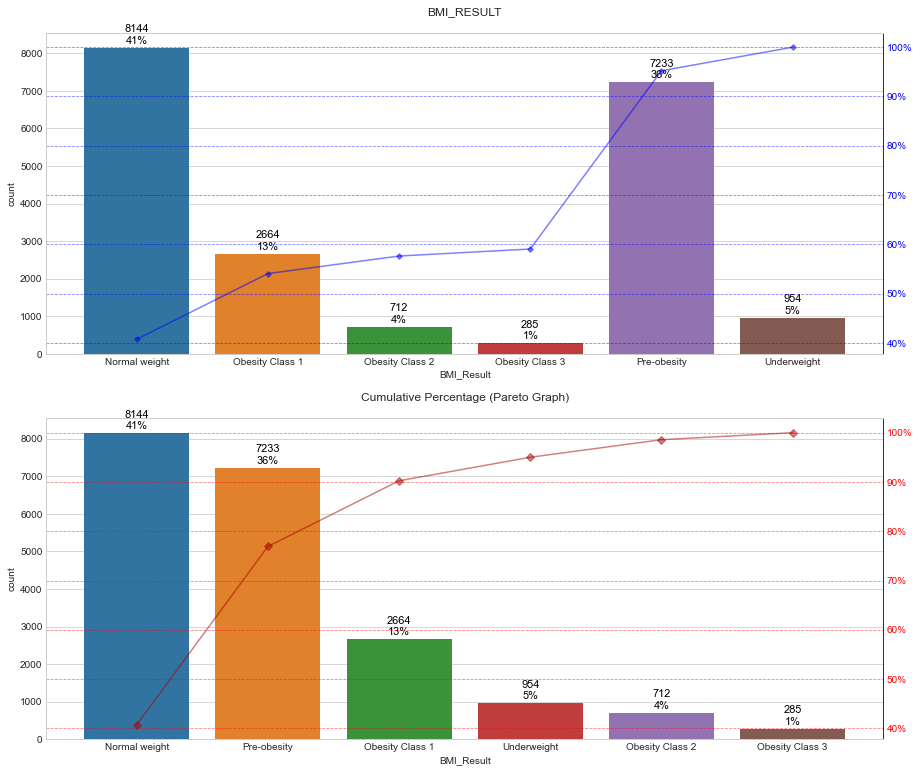

Column: BMI_Result_Coded  (DataType: float64)
N         = 19992 [Non-NaN: 19992]
Missingness: 0 (0.0%)
Min       = 18.00  
Max       = 45.00  
SE / Std  = 5.03  (Standard Error or Std.Dev.)
SEM       = 0.04  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 5.03/sqrt(19992)] 
Mean      = 28.63 +/- 5.03 (Std.Dev.) [Precision of the Mean = 28.63 +/- 0.04 (SEM)] 
Median    = 30.00  
Mode      = 25.0
Variance  = 25.27 (Coefficient of Variation = 0.18)
Skewness  = 0.58 (Right-Skewed) (Moderately Skewed) 
Kurtosis  = 0.95 (leptokurtic, point head appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 25.00]   [Q2: 50% < 30.00]   [Q3: 75% < 30.00]
 -IQR     = 5.000 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 18.000]   [Upper = 37.500]


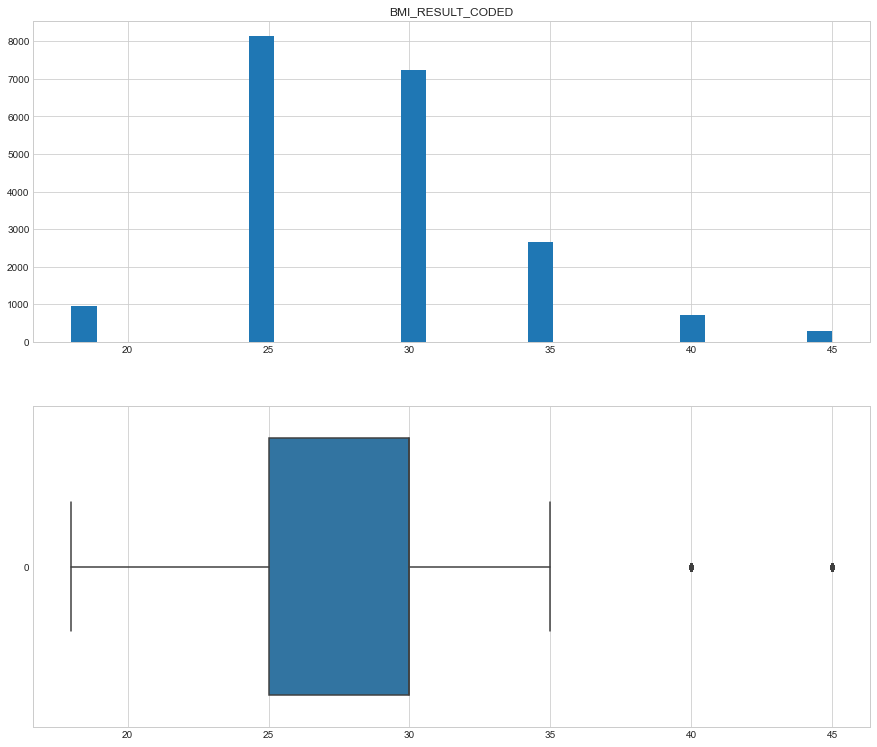

Column: Delta_from_Symptoms_Onset  (DataType: float64)
N         = 19992 [Non-NaN: 19992]
Missingness: 0 (0.0%)
Min       = 0.00  
Max       = 296.00  
SE / Std  = 15.89  (Standard Error or Std.Dev.)
SEM       = 0.11  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 15.89/sqrt(19992)] 
Mean      = 26.51 +/- 15.89 (Std.Dev.) [Precision of the Mean = 26.51 +/- 0.11 (SEM)] 
Median    = 23.00  
Mode      = 19.0
Variance  = 252.61 (Coefficient of Variation = 0.60)
Skewness  = 3.82 (Right-Skewed) (Highly Skewed) 
Kurtosis  = 43.62 (leptokurtic, point head appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 16.00]   [Q2: 50% < 23.00]   [Q3: 75% < 33.00]
 -IQR     = 17.000 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 0.000]   [Upper = 58.500]


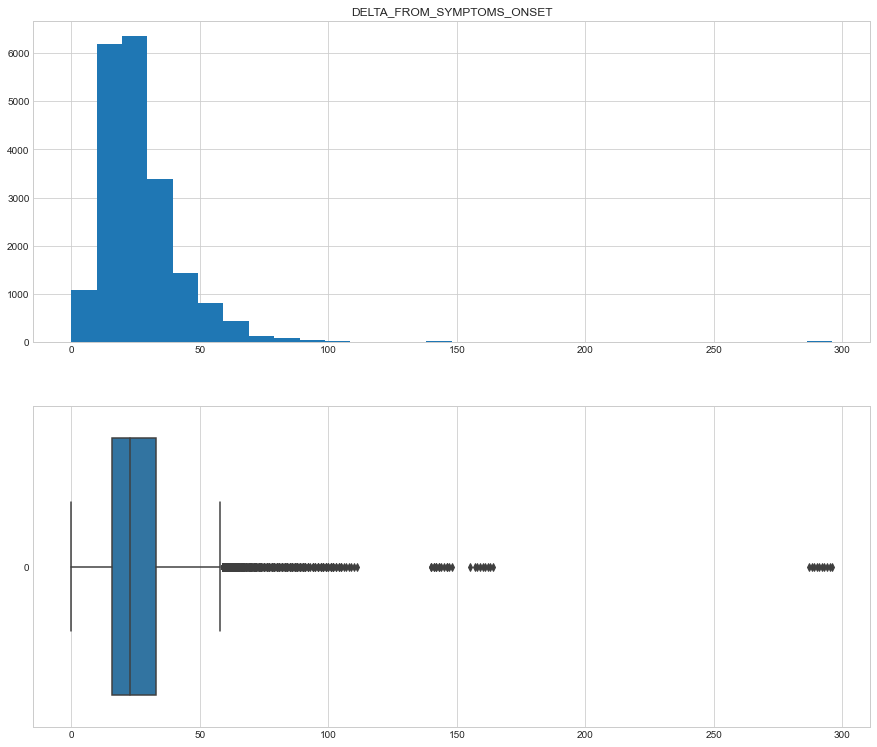

In [35]:
# df_bmi = df.copy()

# # normal weight  : >= 18.5 & < 25.0 
# to_update = df_bmi.loc[(df_bmi.BMI >= 18.5) & (df_bmi.BMI < 25.0 )]
# df_bmi.loc[to_update.index, 'BMI_Result'] = 'Normal weight'
# # df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 0
# df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 25

# # underweight    : < 18.5
# to_update = df_bmi.loc[(df_bmi.BMI < 18.5)]
# df_bmi.loc[to_update.index, 'BMI_Result'] = 'Underweight'
# # df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 1
# df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 18


# # overweight     : >= 25.0 & < 30.0 
# to_update = df_bmi.loc[(df_bmi.BMI >= 25.0) & (df_bmi.BMI < 30.0 )]
# df_bmi.loc[to_update.index, 'BMI_Result'] = 'Pre-obesity'
# # df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 2
# df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 30

# # grade 1 obesity: >= 30.0 & < 35.0 
# to_update = df_bmi.loc[(df_bmi.BMI >= 30.0) & (df_bmi.BMI < 35.0 )]
# df_bmi.loc[to_update.index, 'BMI_Result'] = 'Obesity Class 1'
# # df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 3
# df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 35

# # grade 2 obesity: >= 35.0 & < 40.0 
# to_update = df_bmi.loc[(df_bmi.BMI >= 35.0) & (df_bmi.BMI < 40.0 )]
# df_bmi.loc[to_update.index, 'BMI_Result'] = 'Obesity Class 2'
# # df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 4
# df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 40

# # grade 3 obesity: >= 40.0
# to_update = df_bmi.loc[(df_bmi.BMI >= 40.0 )]
# df_bmi.loc[to_update.index, 'BMI_Result'] = 'Obesity Class 3'
# # df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 5
# df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 45



# df_bmi.sort_values(by=['subject_id', 'Delta_from_Symptoms_Onset'], inplace=True)


# utils.plot_variables_distributions(
#     df=df_bmi, 
#     columns=[
#         'BMI_Result', 
#         'BMI_Result_Coded',
#         'Delta_from_Symptoms_Onset',
#     ],
#     plot_one_graph_per_row=True
# )




----
----
----
### Categorize BMI Results according to "BMI" value
```
 - Severely underweight: < 16.5        Code: 0
 - Underweight         :   16.5-18.5   Code: 1
 - Normal weight       :   18.5–24.9   Code: 2
 - Overweight          :   25.0–29.9   Code: 3
 - Obesity             : >=30.0        Code: 4
```

 Reference: 
 BMI Classification Percentile And Cut Off Points, 2022. 
 available: https://www.ncbi.nlm.nih.gov/books/NBK541070/


Column: BMI_Result_Str  (DataType: object)
N         = 19979 [Non-NaN: 19979]
Missingness: 0 (0.0%)

Summary Table:
                      count percentage
Normal weight          8141     40.75%
Overweight             7230     36.19%
Obesity                3654     18.29%
Underweight             709      3.55%
Severely underweight    245      1.23%


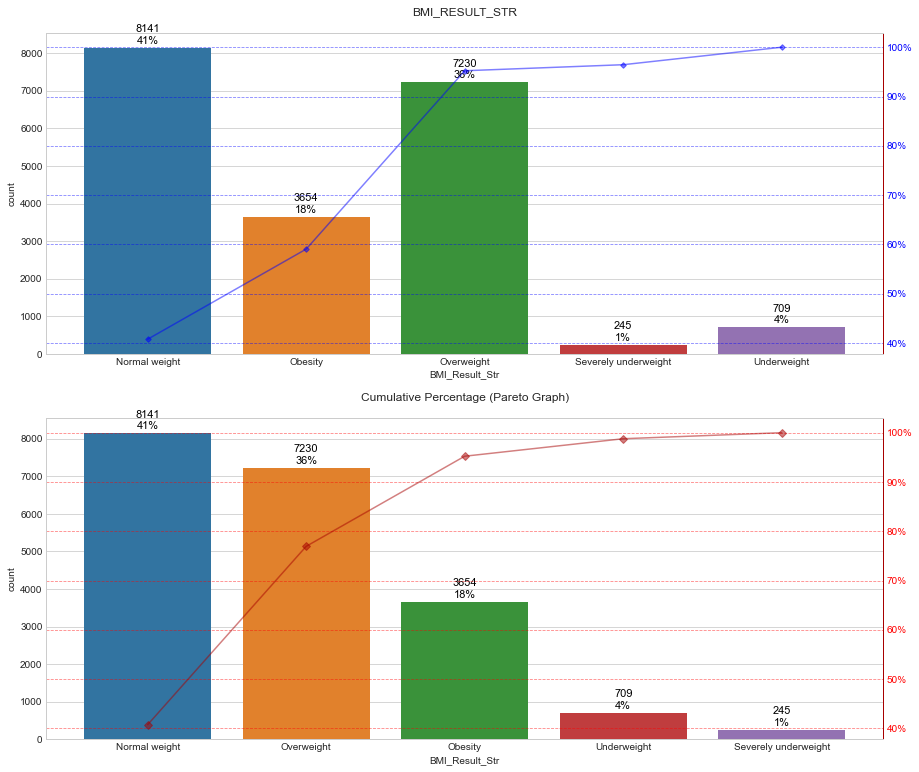

Column: BMI_Result_Coded  (DataType: float64)
N         = 19979 [Non-NaN: 19979]
Missingness: 0 (0.0%)
Min       = 0.00  
Max       = 4.00  
SE / Std  = 0.86  (Standard Error or Std.Dev.)
SEM       = 0.01  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 0.86/sqrt(19979)] 
Mean      = 2.67 +/- 0.86 (Std.Dev.) [Precision of the Mean = 2.67 +/- 0.01 (SEM)] 
Median    = 3.00  
Mode      = 2.0
Variance  = 0.73 (Coefficient of Variation = 0.32)
Skewness  = -0.12 (Left-Skewed) (Approximately Symmetric) 
Kurtosis  = -0.10 (platykurtic, rounded appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 2.00]   [Q2: 50% < 3.00]   [Q3: 75% < 3.00]
 -IQR     = 1.000 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 0.500]   [Upper = 4.000]


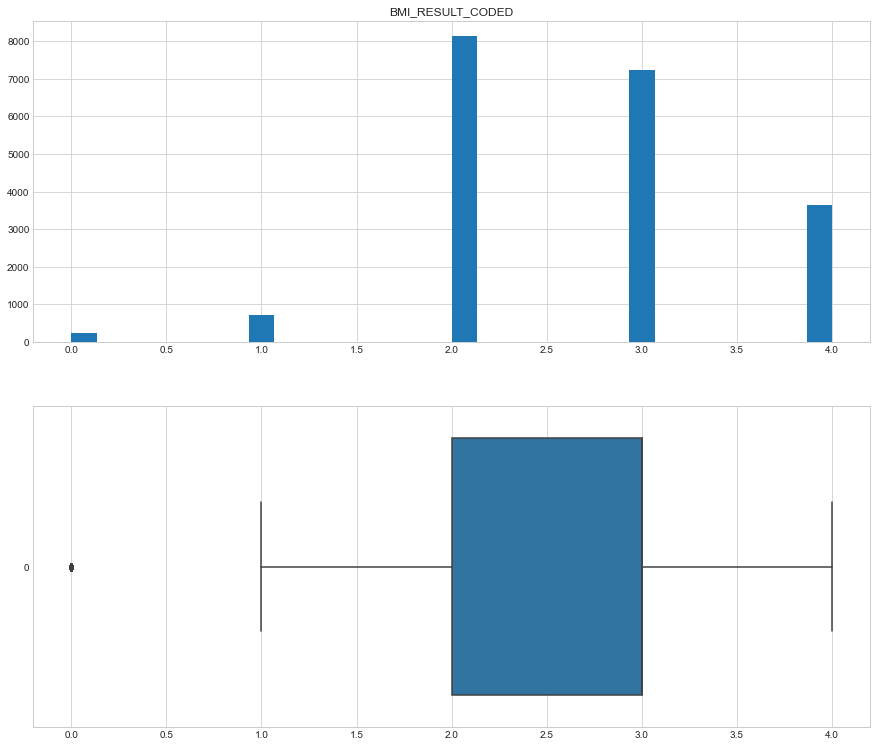

Column: Delta_from_Symptoms_Onset  (DataType: float64)
N         = 19979 [Non-NaN: 19979]
Missingness: 0 (0.0%)
Min       = 0.00  
Max       = 296.00  
SE / Std  = 15.89  (Standard Error or Std.Dev.)
SEM       = 0.11  (Standard Error of the Mean) [Formula: Std.Dev/sqrt(N) => 15.89/sqrt(19979)] 
Mean      = 26.51 +/- 15.89 (Std.Dev.) [Precision of the Mean = 26.51 +/- 0.11 (SEM)] 
Median    = 23.00  
Mode      = 19.0
Variance  = 252.62 (Coefficient of Variation = 0.60)
Skewness  = 3.82 (Right-Skewed) (Highly Skewed) 
Kurtosis  = 43.64 (leptokurtic, point head appearance)(PS: a high kurtosis indicates too many outliers) 
Quartiles = [Q1: 25% < 16.00]   [Q2: 50% < 23.00]   [Q3: 75% < 33.00]
 -IQR     = 17.000 (Interquartile Range: IQR = Q3-Q1)
 -Outliers Threshold (IQR * +/-1.5):  [Lower = 0.000]   [Upper = 58.500]


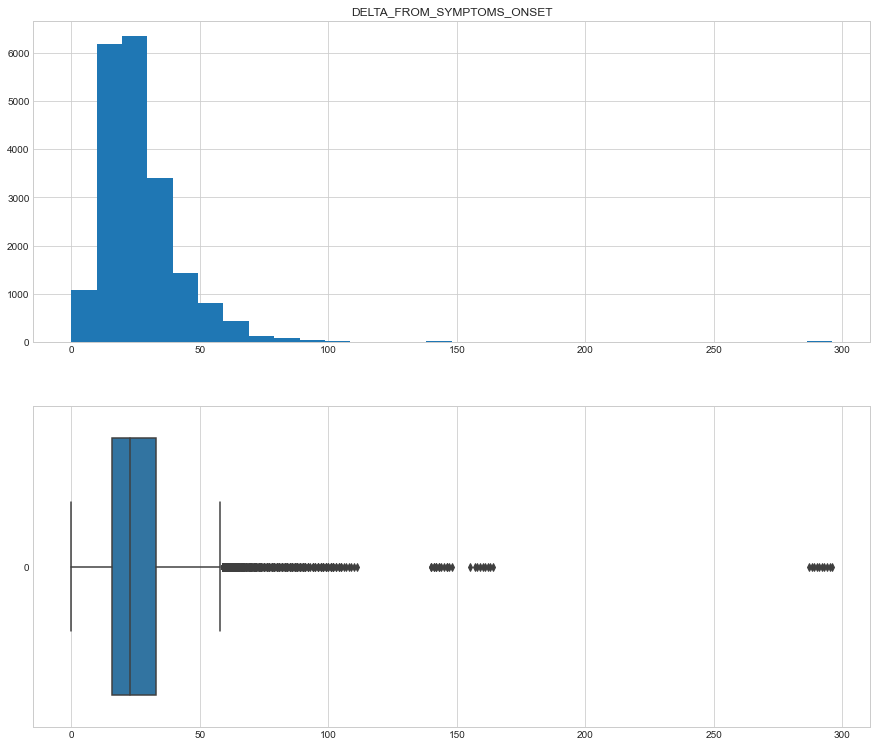

In [18]:
df_bmi = df.copy()

# Severely underweight    : < 16.5
to_update = df_bmi.loc[(df_bmi.BMI < 16.5)]
df_bmi.loc[to_update.index, 'BMI_Result_Str'] = 'Severely underweight'
df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 0

# underweight    : < 18.5
to_update = df_bmi.loc[(df_bmi.BMI >= 16.5) & (df_bmi.BMI < 18.5 )]
df_bmi.loc[to_update.index, 'BMI_Result_Str'] = 'Underweight'
df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 1


# normal weight  : >= 18.5 & < 25.0 
to_update = df_bmi.loc[(df_bmi.BMI >= 18.5) & (df_bmi.BMI < 25.0 )]
df_bmi.loc[to_update.index, 'BMI_Result_Str'] = 'Normal weight'
df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 2

# overweight     : >= 25.0 & < 30.0 
to_update = df_bmi.loc[(df_bmi.BMI >= 25.0) & (df_bmi.BMI < 30.0 )]
df_bmi.loc[to_update.index, 'BMI_Result_Str'] = 'Overweight'
df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 3

# grade 1 obesity: >= 30.0 & < 35.0 
to_update = df_bmi.loc[(df_bmi.BMI >= 30.0)]
df_bmi.loc[to_update.index, 'BMI_Result_Str'] = 'Obesity'
df_bmi.loc[to_update.index, 'BMI_Result_Coded'] = 4


df_bmi.sort_values(by=['subject_id', 'Delta_from_Symptoms_Onset'], inplace=True)


utils.plot_variables_distributions(
    df=df_bmi, 
    columns=[
        'BMI_Result_Str', 
        'BMI_Result_Coded',
        'Delta_from_Symptoms_Onset',
    ],
    plot_one_graph_per_row=True
)




----
----
----
## Plot some distributions


In [19]:
utils.show_columns_stats(df=df)

subject_id....................... = 19979 rows (100.0%)     0 with NaN (  0.0%) Uniques=  3318 
Delta_from_Symptoms_Onset........ = 19979 rows (100.0%)     0 with NaN (  0.0%) Uniques=   139 
Weigth_in_Kilograms.............. = 19979 rows (100.0%)     0 with NaN (  0.0%) Uniques=  1083 
Height_in_Meters................. = 19979 rows (100.0%)     0 with NaN (  0.0%) Uniques=    56 
Delta_from_Symptoms_Onset_in_Days = 19979 rows (100.0%)     0 with NaN (  0.0%) Uniques=  2150 
BMI.............................. = 19979 rows (100.0%)     0 with NaN (  0.0%) Uniques=    52 


----
----
----
## Save the pre-processed data to `Weigth` CSV file

In [20]:
dir_dest = os.path.abspath('../03_proact_preprocessed/')

# save CSv file
csv_dest = f'{dir_dest}/_BMI.csv'
utils.save_to_csv(df=df, csv_file=csv_dest)


19979 samples were saved


---
---
# Generate Time-Series from Symptoms-Onset for each patient

In [21]:
# Get values by month up to 72 months (i.e., 6 years)
n_years = 10
threshold = 12 * n_years # "n" years
months = np.linspace(0, threshold, threshold+1, dtype=float) #[1.0, 2.0, 3.0,..., 72.0]


baselines = [
    'Symptoms_Onset'
]

dir_dest = os.path.abspath('../03_proact_preprocessed/')

for baseline in baselines:

    col_baseline = f'Delta_from_{baseline}'
    
    # copy data ordering by col_baseline
    df_copy = df_bmi.sort_values(by=['subject_id', col_baseline]).copy()
    
    # drop rows with NaN in col_baseline
    df_copy.dropna(
        subset=[
            col_baseline, 
            'BMI', 
            'BMI_Result_Coded'
        ], 
        inplace=True
    )

    # filter rows by threshold
    df_pivot = df_copy.copy()

    # get only the names of the Values columns 
    cols_to_pivot = df_pivot.columns[2:]

    # create pivot by column Result
    df_aux = df_pivot.pivot_table(
        index='subject_id', 
        columns=col_baseline, 
        values='BMI_Result_Coded',
        aggfunc=np.max, # get max value in that month (can exist 2+ measurements for a same month)
    )
    
    # reset index
    df_aux.reset_index(inplace=True)

    # get the month-columns existing in the pivot-table
    cols_months = df_aux.columns[1:]

    # check if all months columns were created [1-72]
    for month in months:
        # if month not present in the columns
        if month not in cols_months:
            # Creating column for this month and set its values to NaN
            # PS: "int(month)" is used to keep columns ordered by month number
            df_aux.insert(int(month), month, np.NaN)

    # code to ensure the order of the columns
    cols_months_ordered = list(sorted(months))
    cols_months_ordered.insert(0, 'subject_id')
    df_aux = df_aux[cols_months_ordered]
            
            
    # save data for each Value column
    print(f'{col_baseline}')
    csv_file = f'{dir_dest}/TimeSeries/without_MI/BMI_TimeSeries_from_{baseline}.csv'
    utils.save_to_csv(df=df_aux, csv_file=csv_file)


    # read file saved to fill NaN values using interpolation
    df_fill_nan_using_interpolation = pd.read_csv(csv_file, delimiter=',')
    # get columns ignoring 'subject_id'
    cols_months = df_fill_nan_using_interpolation.columns[1:]

    # print (cols_months)
    df_aux = df_fill_nan_using_interpolation[cols_months].interpolate(
        method='linear', 
        limit_direction='both',
        limit=1000, 
        axis=1, 
        inplace=False,
    ).copy()

    # round Values using 0 decimal places
    df_aux[cols_months] = np.round(df_aux[cols_months], 0)

    # get subject_id column
    df_fill_nan_using_interpolation[cols_months] = df_aux[cols_months]

    # drop rows with NaN values (where there is no Value registered)
    df_fill_nan_using_interpolation.dropna(inplace=True)

    # save data again for each Value column with interpolation
    print(f'{col_baseline} with_Missing_Imputation')
    csv_file = f'{dir_dest}/TimeSeries/BMI_TimeSeries_from_{baseline}_with_MI.csv'
    utils.save_to_csv(df=df_fill_nan_using_interpolation, csv_file=csv_file)

    # just for further tests
    df_aux = df_fill_nan_using_interpolation.copy()
    
    print()



Delta_from_Symptoms_Onset
3318 samples were saved
Delta_from_Symptoms_Onset with_Missing_Imputation
3314 samples were saved

